In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
### TEP 
en_dataset = drive.CreateFile({'id':"1y7t0_Kn9OUf1qloRbX1LgKs90qK2Me7A"})
fa_dataset = drive.CreateFile({'id':"12TRsshOfVbtwtZRGrbpe3nVUUKzKy9xF"})

### MIZAN
# en_dataset = drive.CreateFile({'id':"1cUSdRyyeHA8U8Jy1j3XYAqVcCrEDSbWC"})
# fa_dataset = drive.CreateFile({'id':"1WySMrk1LIDUY-5_fkg9RK6Neu_wdeSVB"})

### PEPC
# en_dataset = drive.CreateFile({'id':"1w6Z7f6oba0NgzvsQyT09-wfsfnCgM61b"})
# fa_dataset = drive.CreateFile({'id':"1xUMlPv52JSsxQqXkjvzAJamG66mdD8Nn"})


en_dataset.GetContentFile('en_dataset.txt')
fa_dataset.GetContentFile('fa_dataset.txt')

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

from ipywidgets import IntProgress
from IPython.display import display
import time

In [ ]:
arabic_to_persian = {'ﺎ':'ا','ﺍ':'ا','ﺑ':'ب','ﺒ':'ﺐ','ﺐ':'ب','ﺏ':'ب','ﺗ':'ت','ﺘ':'ت','ﺖ':'ت','ﺕ':'ت','ﺛ':'ث','ﺜ':'ث','ﺚ':'ث','ﺙ':'ث','ﺟ':'ج','ﺠ':'ج','ﺞ':'ج','ﺝ':'ج','ﺣ':'ح','ﺤ':'ح','ﺢ':'ح','ﺡ':'ح','ﺧ':'خ','ﺨ':'خ','ﺦ':'خ','ﺥ':'خ','ﺪ':'د','ﺩ':'د','ﺬ':'ذ','ﺫ':'ذ','ﺮ':'ر','ﺭ':'ر','ﺰ':'ز','ﺯ':'ز','ﺳ':'س','ﺴ':'س','ﺲ':'س','ﺱ':'س','ﺷ':'ش','ﺸ':'ش','ﺶ':'ش','ﺵ':'ش','ﺻ':'ص','ﺼ':'ص','ﺺ':'ص','ﺹ':'ص','ﺿ':'ض','ﻀ':'ض','ﺾ':'ض','ﺽ':'ض','ﻃ':'ط','ﻄ':'ط','ﻂ':'ط','ﻁ':'ط','ﻇ':'ظ','ﻈ':'ظ','ﻆ':'ظ','ﻅ':'ظ','ﻋ':'ع','ﻌ':'ع','ﻊ':'ع','ﻉ':'ع','ﻏ':'غ','ﻐ':'غ','ﻎ':'غ','ﻍ':'غ','ﻓ':'ف','ﻔ':'ف','ﻒ':'ف','ﻑ':'ف','ﻗ':'ق','ﻘ':'ق','ﻖ':'ق','ﻕ':'ق','ﻛ':'ک','ﻜ':'ک','ﻚ':'ک','ﻙ':'ک','ﻟ':'ل','ﻠ':'ل','ﻞ':'ل','ﻝ':'ل','ﻣ':'م','ﻤ':'م','ﻢ':'م','ﻡ':'م','ﻧ':'ن','ﻨ':'ن','ﻦ':'ن','ﻥ':'ن','ﻫ':'ه','ﻬ':'ه','ﻪ':'ه','ﻩ':'ه','ﻮ':'و','ﻭ':'و','ﻳ':'ی','ﻴ':'ی','ﻲ':'ی','ﻱ':'ی','ﺂ':'آ','ﺁ':'آ','ﺔ':'ه','ﺓ':'ه','ﻰ':'ی','ﻯ':'ی','ئ':'ی','ﭖ':'پ','ﭻ':'چ','ڗ':'ژ','ٶ':'و','ۯ':'ژ','ٱ':'ا','ﺅ':'و','ﮔ':'گ','ﯿ':'ی','ى':'ی','ۃ':'ه','ە':'ه','ة':'ه','ہ':'ه','أ':'ا','ك':'ک','إ':'ا','ۀ':'ه','ھ':'ه','ۆ':'و','ﮐ':'ک','ﭘ':'پ','ﺐ':'ب','ﮏ':'ک','ﭼ':'چ','ﯾ':'ی','ﮕ':'گ','ﮋ':'ژ','ﮑ':'ک','ﭽ':'چ','ۍ':'ی','ﯼ':'ی','ﺆ':'و','ﺌ':'ی','ﺄ':'ا','ﭗ':'پ','ﮎ':'ک','ﮒ':'گ','ګ':'گ','ﭙ':'پ','ﺋ':'ی','ﮓ':'گ','ي':'ی','ﯽ':'ی'}

In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence_en(w):
  w = unicode_to_ascii(w.lower().strip())

  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)

  w = w.strip()

  w = '<start> ' + w + ' <end>'
  return w

def preprocess_sentence_fa(w):
  for arb in arabic_to_persian.keys():
    w = w.replace(arb, arabic_to_persian[arb])
  
  w = re.sub(r"([.؛؟])", r" \1 ", w)
  w = re.sub('[^آابپتثجچحخدذرزژسشصضطظعغفقکگلمنوهی\d.؛؟\s]+', ' ', w)
  w = re.sub('[\x0c\r\x1f\x85\xa0\u2003\u2005\u2009\u200a\u2028\u2029\u202f\u3000\u200c]' ,' ' ,w)
  w = re.sub('\.+', '.', w)
  w = re.sub('[\s+]', ' ', w)
  w = w.strip()
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
en_sentence = u"May I borrow this book?"
fa_sentence = u"آیا می‌توانم این کتاب را قرض بگیرم؟"
print(preprocess_sentence_en(en_sentence))
print(preprocess_sentence_fa(fa_sentence))

<start> may i borrow this book ? <end>
<start> آیا می توانم این کتاب را قرض بگیرم ؟ <end>


In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, PERSIAN]
def create_dataset(source_path, target_path, num_examples):
  source_lines = io.open(source_path, encoding='UTF-8').read().strip().split('\n')[:num_examples]
  target_lines = io.open(target_path, encoding='UTF-8').read().strip().split('\n')[:num_examples]

  word_pairs = []

  for src, trgt in zip(source_lines, target_lines):
    word_pairs.append([preprocess_sentence_en(src), preprocess_sentence_fa(trgt)])

  return zip(*word_pairs)

In [ ]:
en, fa = create_dataset('en_dataset.txt', 'fa_dataset.txt', 2000)
print(en[-1])
print(fa[-1])

<start> its better . cheaper , too . <end>
<start> بهتره ارزون ترم هست  . <end>


In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(source_path, target_path, num_examples=None):
  # creating cleaned input, output pairs
  inp_lang, targ_lang = create_dataset(source_path, target_path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 200000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset('en_dataset.txt', 'fa_dataset.txt', num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = train_test_split(input_tensor, target_tensor, test_size=0.05)
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor_train, target_tensor_train, test_size=0.05)

# Show length
print(len(input_tensor_train), len(input_tensor_val), len(input_tensor_test))

180500 9500 10000


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
2 ----> <start>
10154 ----> cory
4 ----> ,
89 ----> look
57 ----> at
6 ----> the
23211 ----> ferns
1 ----> .
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
2117 ----> کری
30786 ----> سرخسها
5 ----> را
133 ----> نگاه
28 ----> کن
1 ----> .
3 ----> <end>


In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 128
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 38]), TensorShape([128, 35]))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (128, 38, 1024)
Encoder Hidden state shape: (batch size, units) (128, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (128, 38, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 50497)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 50

prev_loss = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

  if (total_loss / steps_per_epoch) > prev_loss:
    print('Early Stopping')
    break
  else:
    prev_loss = (total_loss / steps_per_epoch)


Epoch 1 Batch 0 Loss 2.6470
Epoch 1 Batch 100 Loss 1.6018
Epoch 1 Batch 200 Loss 1.6900
Epoch 1 Batch 300 Loss 1.4843
Epoch 1 Batch 400 Loss 1.5595
Epoch 1 Batch 500 Loss 1.5562
Epoch 1 Batch 600 Loss 1.4174
Epoch 1 Batch 700 Loss 1.4662
Epoch 1 Batch 800 Loss 1.3175
Epoch 1 Batch 900 Loss 1.3691
Epoch 1 Batch 1000 Loss 1.3402
Epoch 1 Batch 1100 Loss 1.3303
Epoch 1 Batch 1200 Loss 1.2194
Epoch 1 Batch 1300 Loss 1.3194
Epoch 1 Batch 1400 Loss 1.2831
Epoch 1 Loss 1.4462
Time taken for 1 epoch 1398.7835447788239 sec

Epoch 2 Batch 0 Loss 1.3300
Epoch 2 Batch 100 Loss 1.1308
Epoch 2 Batch 200 Loss 1.1770
Epoch 2 Batch 300 Loss 1.1853
Epoch 2 Batch 400 Loss 1.2277
Epoch 2 Batch 500 Loss 1.1406
Epoch 2 Batch 600 Loss 1.1204
Epoch 2 Batch 700 Loss 1.0836
Epoch 2 Batch 800 Loss 1.0625
Epoch 2 Batch 900 Loss 1.1268
Epoch 2 Batch 1000 Loss 1.1432
Epoch 2 Batch 1100 Loss 1.0183
Epoch 2 Batch 1200 Loss 1.0474
Epoch 2 Batch 1300 Loss 1.1056
Epoch 2 Batch 1400 Loss 0.9245
Epoch 2 Loss 1.1187
Time ta

KeyboardInterrupt: ignored

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence_en(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence, verbose=True):
  result, sentence, attention_plot = evaluate(sentence)

  if verbose:
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))
  else:
    return result

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> there is a cat on the wall <end>
Predicted translation: یک گربه روی دیوار وال . <end> 


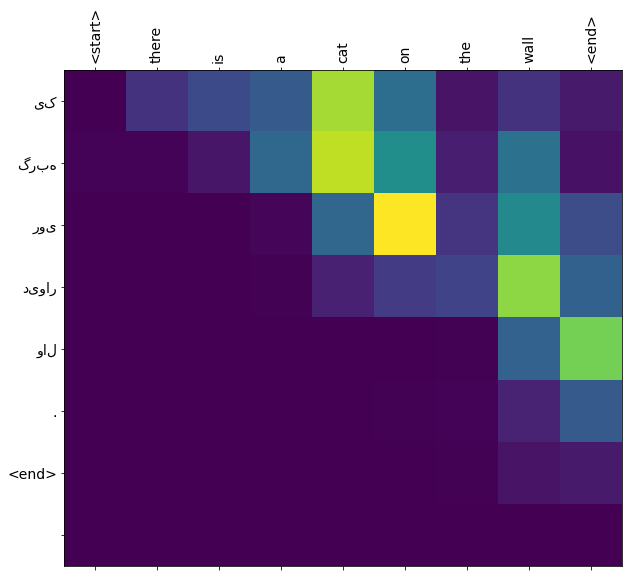

In [ ]:
translate(u'there is a cat on the wall')

reference: <start> تازه تو میتونی پسر منو ببینی . <end>
Input: <start> but it might be worth it . you know , you could meet my son . <end>
Predicted translation: اما این ممکنه که ارزشش را داشته باشه میدونی میتونی پسر منو ببینی . <end> 


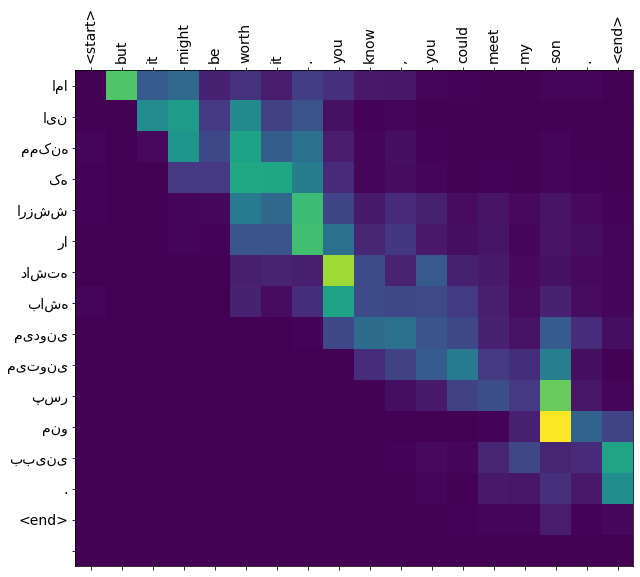

bleu score (unigram, bigram, trigram, 4gram) = 0.31314224813827346
bleu score (unigram, bigram, trigram) = 0.36744446004373293
bleu score (unigram, bigram) = 0.38188130791298663
---------------------------------------------------------------------
reference: <start> این را فراموش نکن . <end>
Input: <start> dont forget that . <end>
Predicted translation: اینو فراموش نکن . <end> 


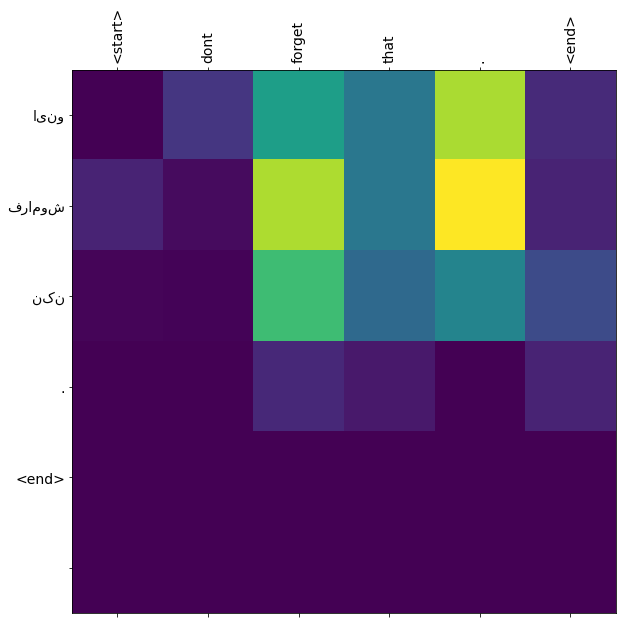

bleu score (unigram, bigram, trigram, 4gram) = 0.4548019047027907
bleu score (unigram, bigram, trigram) = 0.5718831188567616
bleu score (unigram, bigram) = 0.5985529678206387
---------------------------------------------------------------------
reference: <start> چقدر میشه . <end>
Input: <start> how much . <end>
Predicted translation: چنده . صد تومن . <end> 


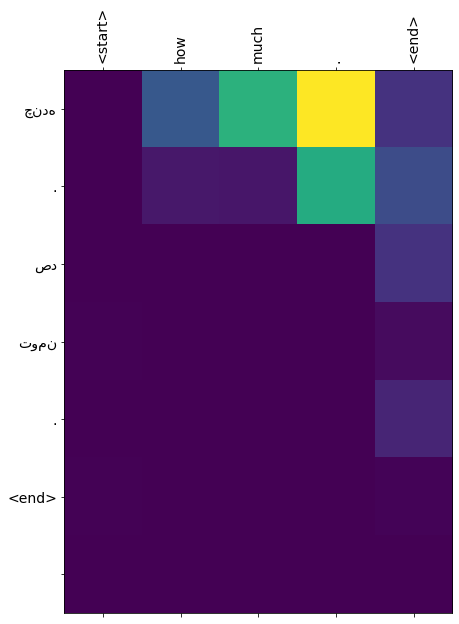

bleu score (unigram, bigram, trigram, 4gram) = 0.23016915699647844
bleu score (unigram, bigram, trigram) = 0.2860927295597968
bleu score (unigram, bigram) = 0.26726124191242434
---------------------------------------------------------------------
reference: <start> الان چند وقته که اینجاست . <end>
Input: <start> how long has he been here now . <end>
Predicted translation: تا کی مال کیه . <end> 


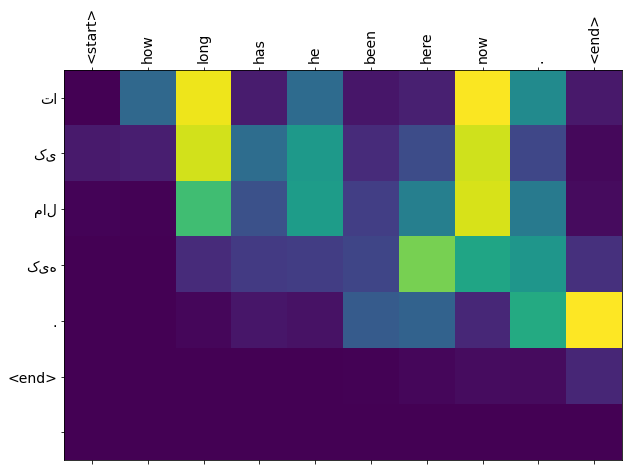

bleu score (unigram, bigram, trigram, 4gram) = 0.19952855540437708
bleu score (unigram, bigram, trigram) = 0.24800746453459338
bleu score (unigram, bigram) = 0.23168286407366764
---------------------------------------------------------------------
reference: <start> ببخشید . من فکر کردم تو . دی جی . <end>
Input: <start> sorry . l thought you were dj . <end>
Predicted translation: ببخش فکر کردم جی جی صدا کنی . <end> 


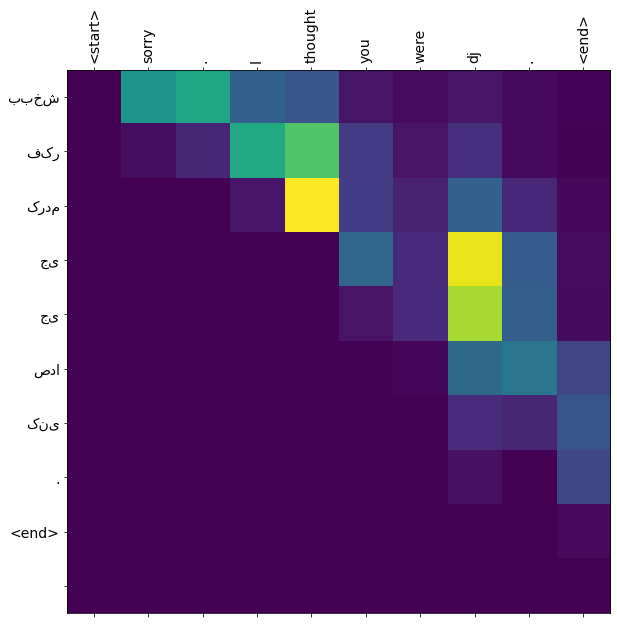

bleu score (unigram, bigram, trigram, 4gram) = 0.2295619424538349
bleu score (unigram, bigram, trigram) = 0.30467811253667865
bleu score (unigram, bigram) = 0.29895820132266854
---------------------------------------------------------------------
reference: <start> بمیری استیون . <end>
Input: <start> earth to steven . <end>
Predicted translation: به خاطر پیدا شدن . <end> 


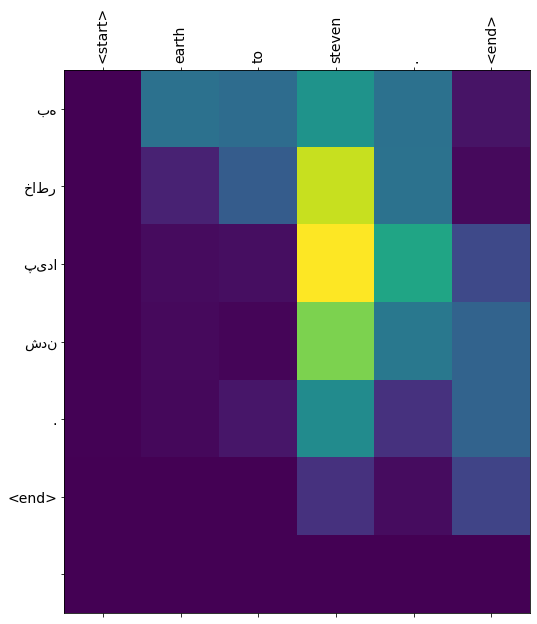

bleu score (unigram, bigram, trigram, 4gram) = 0.23016915699647844
bleu score (unigram, bigram, trigram) = 0.2860927295597968
bleu score (unigram, bigram) = 0.26726124191242434
---------------------------------------------------------------------
reference: <start> اونم تو زندگی شخصیم . <end>
Input: <start> and thats if my life has personally involved . <end>
Predicted translation: و این زندگی من در این باره دیگه است . <end> 


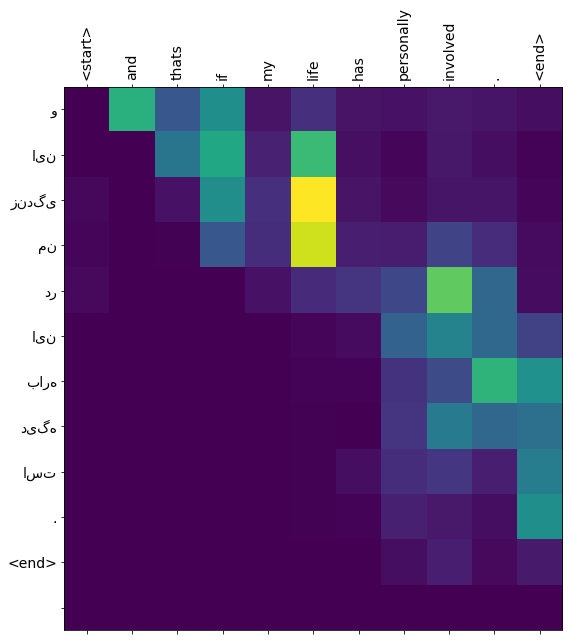

bleu score (unigram, bigram, trigram, 4gram) = 0.19702498636547824
bleu score (unigram, bigram, trigram) = 0.22399945647371902
bleu score (unigram, bigram) = 0.1740776559556978
---------------------------------------------------------------------
reference: <start> باشه بخودت برس . <end>
Input: <start> right . behave yourself . <end>
Predicted translation: درسته خجالت بکش . <end> 


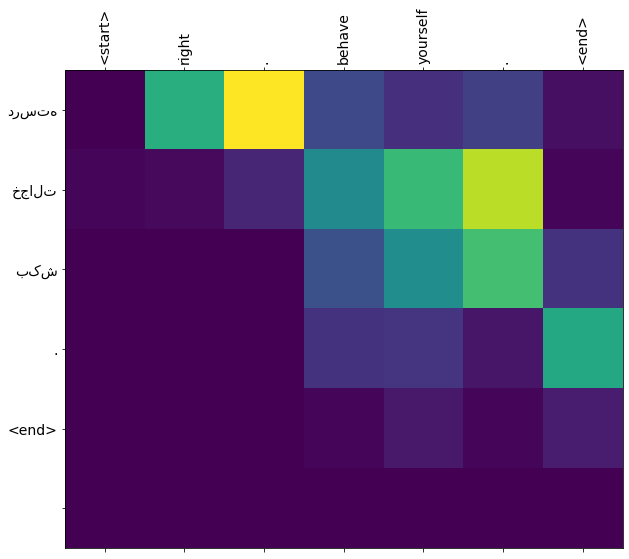

bleu score (unigram, bigram, trigram, 4gram) = 0.2450324327954738
bleu score (unigram, bigram, trigram) = 0.3196289335377037
bleu score (unigram, bigram) = 0.316227766016838
---------------------------------------------------------------------
reference: <start> کلید کامیون خودت را نداری . <end>
Input: <start> you dont have keys to your own truck . <end>
Predicted translation: تو کلید توی کیسه ی نداری . <end> 


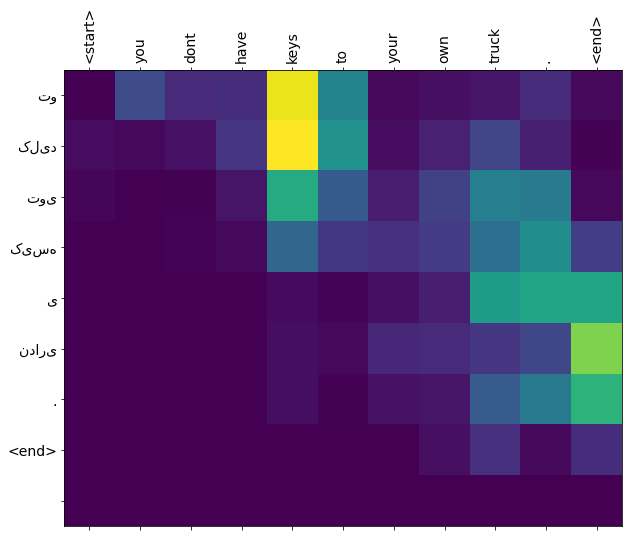

bleu score (unigram, bigram, trigram, 4gram) = 0.24764207868423957
bleu score (unigram, bigram, trigram) = 0.324021806968994
bleu score (unigram, bigram) = 0.372677996249965
---------------------------------------------------------------------
reference: <start> من نمیتونم اینو باور کنم نمیتونم باور کنم که ما برای این مدرسه نمیجنگیم . <end>
Input: <start> i cant believe this . i cant believe were not going to fight for this school . <end>
Predicted translation: کارین نمی تونم باور کنم باورم نمیشه به این مدرسه استفاده نکرده . <end> 


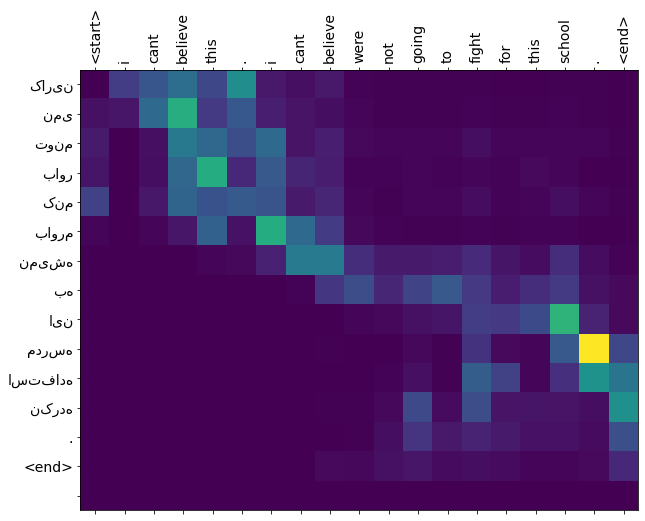

bleu score (unigram, bigram, trigram, 4gram) = 0.23685269672619214
bleu score (unigram, bigram, trigram) = 0.2904582073691017
bleu score (unigram, bigram) = 0.2767541035584926
---------------------------------------------------------------------
reference: <start> اون میدونه کجا میشه تخم عقاب پیدا کرد . <end>
Input: <start> he know wheres to find eagle eggs . <end>
Predicted translation: اون میدونه کجا برای پیدا کردن کجا پیدا بشه . <end> 


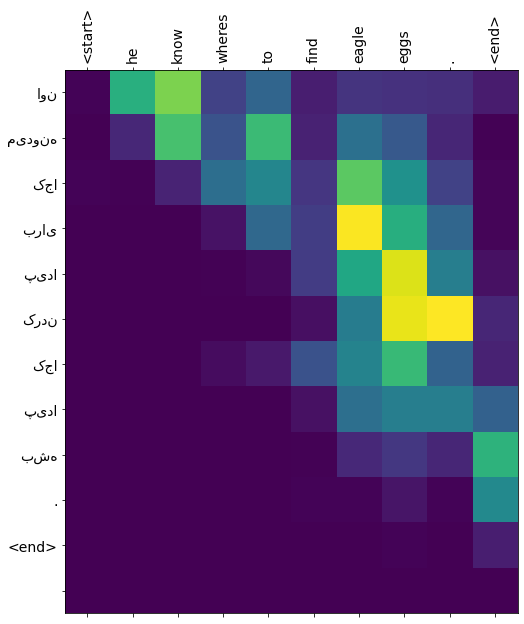

bleu score (unigram, bigram, trigram, 4gram) = 0.2620251007173262
bleu score (unigram, bigram, trigram) = 0.3966274085857194
bleu score (unigram, bigram) = 0.46056618647183833
---------------------------------------------------------------------
reference: <start> لولا داری میری خرید من شامپو میخوام . <end>
Input: <start> lola , are you going shopping l need shampoo . <end>
Predicted translation: لولاداری میری خرید من شامپو میخوام . <end> 


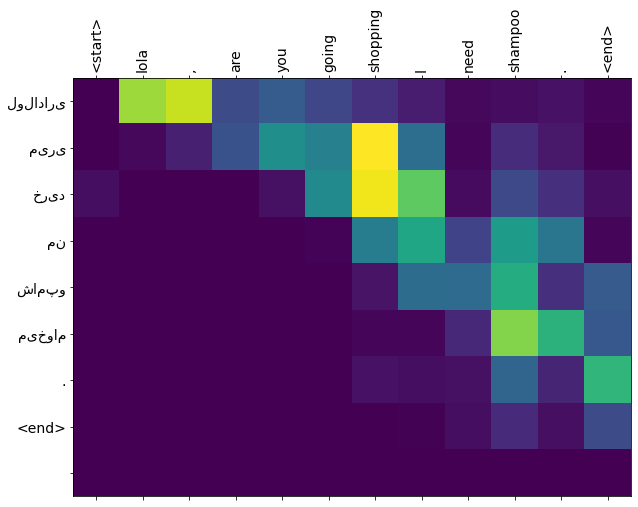

bleu score (unigram, bigram, trigram, 4gram) = 0.6716877364745231
bleu score (unigram, bigram, trigram) = 0.7217754451901375
bleu score (unigram, bigram) = 0.730633242658635
---------------------------------------------------------------------
reference: <start> اون مستقیم به طرف من اومد و بهم گفت اگر گرسنه ام . <end>
Input: <start> she walks straight up to me and asks me if im hungry . <end>
Predicted translation: اون مستقیم به من را ازم فرار کرد و من گرسنه بشم . <end> 


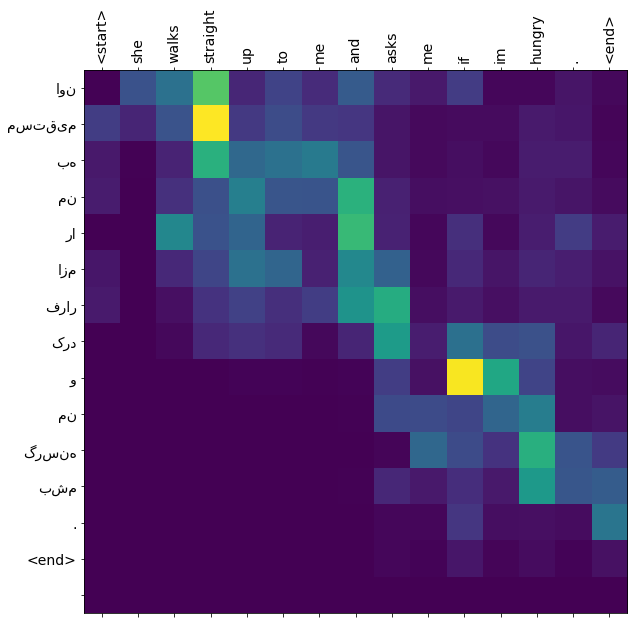

bleu score (unigram, bigram, trigram, 4gram) = 0.21651956746181059
bleu score (unigram, bigram, trigram) = 0.35467475298733936
bleu score (unigram, bigram) = 0.4140393356054125
---------------------------------------------------------------------
reference: <start> داری بهترین سال های عمرت را نابود میکنی . <end>
Input: <start> youre ruining the best years of your life . <end>
Predicted translation: داری بهترین سالهای عمرتو تباه میکنی . <end> 


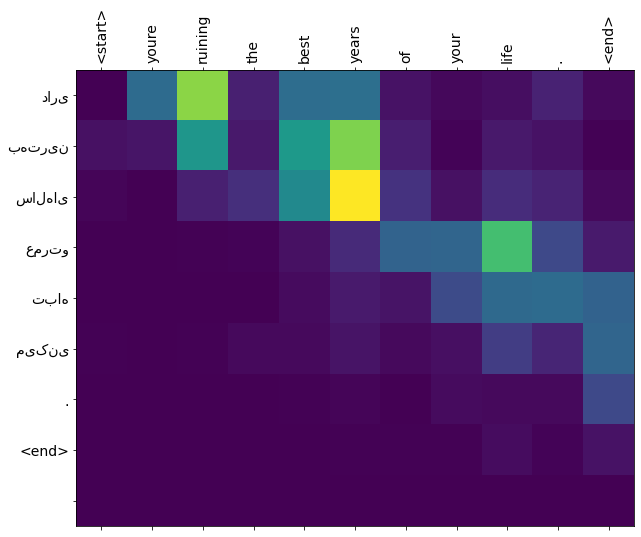

bleu score (unigram, bigram, trigram, 4gram) = 0.29351132655377266
bleu score (unigram, bigram, trigram) = 0.40194809583392677
bleu score (unigram, bigram) = 0.46230595512422085
---------------------------------------------------------------------
reference: <start> خوب چه احساسی داری . <end>
Input: <start> well , how are you feeling . <end>
Predicted translation: خوب چه احساسی داری . <end> 


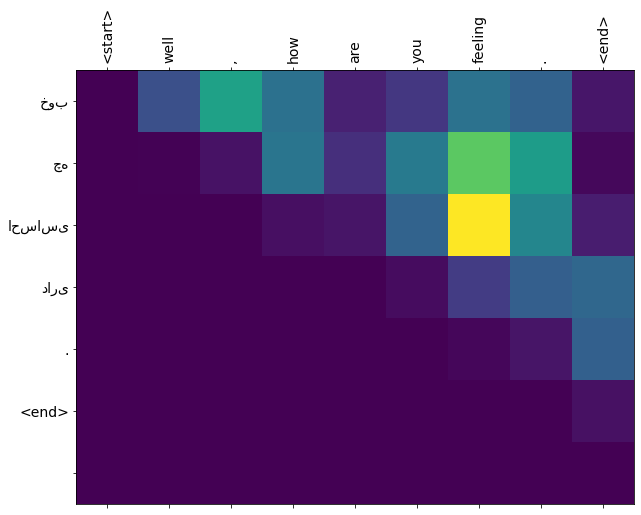

bleu score (unigram, bigram, trigram, 4gram) = 1.0
bleu score (unigram, bigram, trigram) = 1.0
bleu score (unigram, bigram) = 1.0
---------------------------------------------------------------------
reference: <start> همون طور که به شریکم کردی . من هم حساب تو را خواهم رسید . <end>
Input: <start> hou vol . what are you waiting , nigger . <end>
Predicted translation: مقاومت کن دیسکانت مقاومت بکن . <end> 


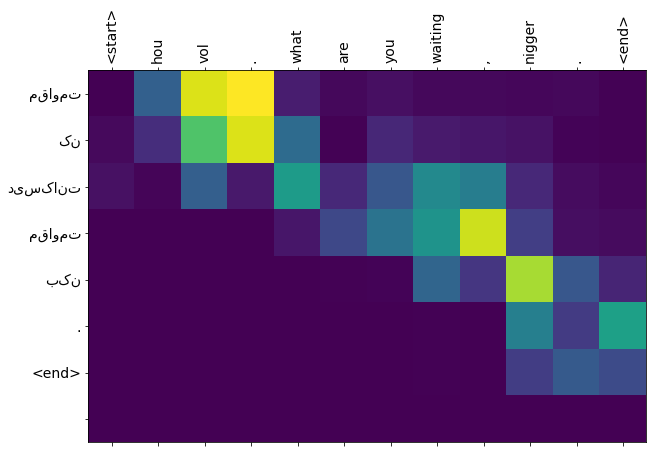

bleu score (unigram, bigram, trigram, 4gram) = 0.07071138613827564
bleu score (unigram, bigram, trigram) = 0.08436957897588661
bleu score (unigram, bigram) = 0.0751424449302781
---------------------------------------------------------------------
reference: <start> عزیزم چیزهایی اتفاق افتاده که من دیگه . نمیتونم اونها را به حالت اولشون برگردونم . <end>
Input: <start> baby , things happened . i cant take em back . <end>
Predicted translation: عزیزم همه چیز افتاده . نمیتونم بر نمیگردیم . <end> 


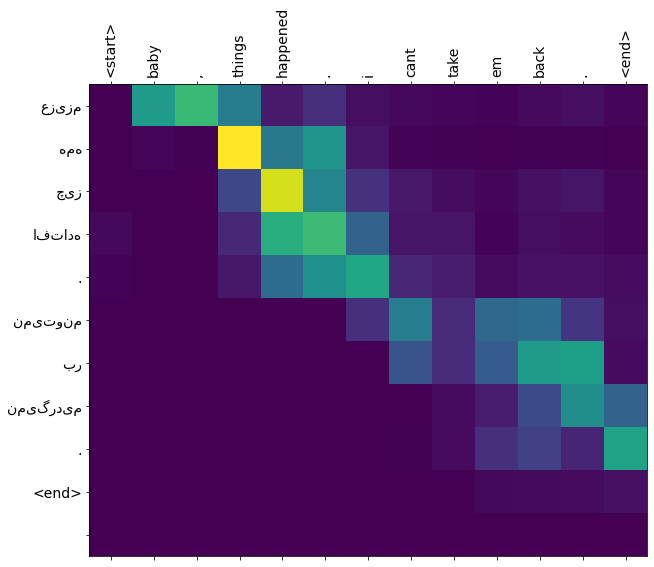

bleu score (unigram, bigram, trigram, 4gram) = 0.16385470618963302
bleu score (unigram, bigram, trigram) = 0.21976648176304966
bleu score (unigram, bigram) = 0.23122995200084864
---------------------------------------------------------------------
reference: <start> تو میتونی این کار را بکنی زودباش زودباش . <end>
Input: <start> you can do it . come on . come on . <end>
Predicted translation: تو میتونی انجامش بده بیا بیا . <end> 


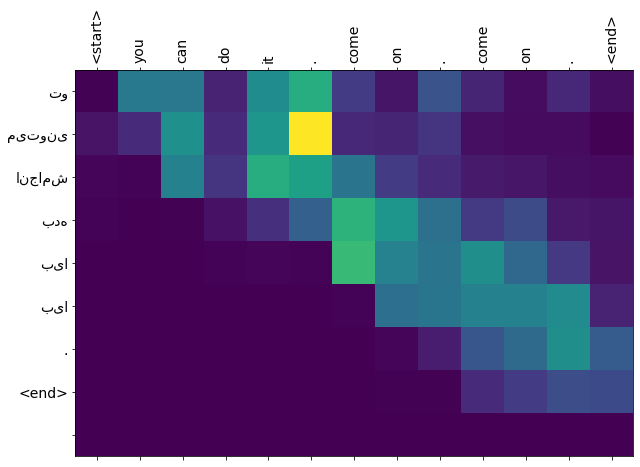

bleu score (unigram, bigram, trigram, 4gram) = 0.21945090221840377
bleu score (unigram, bigram, trigram) = 0.2871356849190775
bleu score (unigram, bigram) = 0.36548494851303226
---------------------------------------------------------------------
reference: <start> لطفا منو تنها نذار . <end>
Input: <start> please , you dont have to leave me . <end>
Predicted translation: خواهش میکنم نباید منو ترک کنی . <end> 


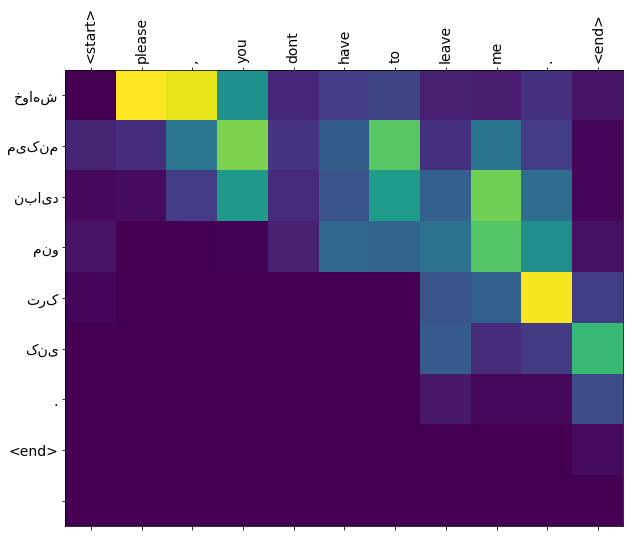

bleu score (unigram, bigram, trigram, 4gram) = 0.22277411682906492
bleu score (unigram, bigram, trigram) = 0.2756684257824437
bleu score (unigram, bigram) = 0.23570226039551587
---------------------------------------------------------------------
reference: <start> از این به بعد تو به عنوان . جیسون بورن شناخته میشی . <end>
Input: <start> from now on you will be known as jason bourne . <end>
Predicted translation: از الان به عنوان دلیل بورن را به نام جیسون بورن را به نام خواهی تویه . <end> 


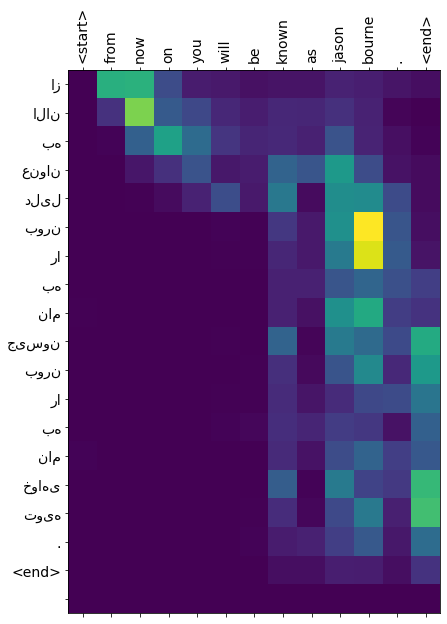

bleu score (unigram, bigram, trigram, 4gram) = 0.27899281153531125
bleu score (unigram, bigram, trigram) = 0.34075809590728007
bleu score (unigram, bigram) = 0.32444284226152503
---------------------------------------------------------------------


In [ ]:
smoothie = SmoothingFunction().method4

cnt = 0

for input, target in zip(input_tensor_test, target_tensor_test):

  cnt += 1
  if cnt > 20:
    break

  input_str = ''
  target_list = []

  for i in input:
    if i != 0 and i != 2 and i != 3:
      input_str += inp_lang.index_word[i] + ' '

  for t in target:
    if t != 0:
      target_list.append(targ_lang.index_word[t])

  reference = [target_list]
  
  candidate = translate(input_str, False).split()
  candidate.insert(0, '<start>')

  print('reference: ' + ' '.join(target_list))
  translate(input_str)

  print('bleu score (unigram, bigram, trigram, 4gram) = ' + str(sentence_bleu(reference, candidate, smoothing_function=smoothie, weights=(0.25, 0.25, 0.25, 0.25))))
  print('bleu score (unigram, bigram, trigram) = ' + str(sentence_bleu(reference, candidate, smoothing_function=smoothie, weights=(0.5, 0.25, 0.25, 0))))
  print('bleu score (unigram, bigram) = ' + str(sentence_bleu(reference, candidate, smoothing_function=smoothie, weights=(0.5, 0.5, 0, 0))))
  print('---------------------------------------------------------------------')


In [ ]:
f = IntProgress(min=0, max=len(input_tensor_test)) # instantiate progress bar
display(f)

smoothie = SmoothingFunction().method4

scores_2 = 0
scores_3 = 0
scores_4 = 0

for input, target in zip(input_tensor_test, target_tensor_test):
  
  f.value += 1 # increase progress bar counter

  input_str = ''
  target_list = []

  for i in input:
    if i != 0 and i != 2 and i != 3:
      input_str += inp_lang.index_word[i] + ' '

  for t in target:
    if t != 0:
      target_list.append(targ_lang.index_word[t])

  reference = [target_list]
  
  candidate = translate(input_str, False).split()
  candidate.insert(0, '<start>')

  scores_2 += sentence_bleu(reference, candidate, smoothing_function=smoothie, weights=(0.5, 0.5, 0, 0))
  scores_3 += sentence_bleu(reference, candidate, smoothing_function=smoothie, weights=(0.5, 0.25, 0.25))
  scores_4 += sentence_bleu(reference, candidate, smoothing_function=smoothie, weights=(0.25, 0.25, 0.25, 0.25))

print('bleu score (unigram, bigram, trigram, 4gram) = ' + str(scores_4 / len(input_tensor_test)))
print('bleu score (unigram, bigram, trigram) = ' + str(scores_3 / len(input_tensor_test)))
print('bleu score (unigram, bigram) = ' + str(scores_2 / len(input_tensor_test)))

IntProgress(value=0, max=10000)

bleu score (unigram, bigram, trigram, 4gram) = 0.2800607710166595
bleu score (unigram, bigram, trigram) = 0.3493847575593439
bleu score (unigram, bigram) = 0.3621666963320763
